In [ ]:
# Sean Dougherty
# 03/15/2022
# this file reads in the output csv filed from agn_merger.py and does some preliminary visualization
# will later become a .py file for sharing and convinience

In [ ]:
# at the end of csv processing, we want a df with bins as columns and iterations as rows
# we want 3 of these: for pair AGN fraction, iso AGN fraction, and enhancement

In [2]:
# load libraries
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

import os

from time import sleep
from tqdm import tqdm

data_path = '/nobackup/c1029594/CANDELS_AGN_merger_data/agn_merger_output/'

## Checking pair and control galaxy mass and redshift distributions

In [ ]:
# do I want to do this by bin? or per iteration?
# probably best to just randomly choose 2 or 3 iterations to look at this for

# generate a 2 random integers to look at distributions
idx = random.randint(len(os.listdir(data_path)), size=2)

# open each dataframe and plot distributions
for file_idx in idx:
    ran_df = pd.read_csv( data_path+(os.listdir(data_path))[file_idx] )
    
    # create arrays for distributions
    histp_z = np.concatenate( (np.array(ran_df['prime_drawn_z']), np.array(ran_df['partner_drawn_z'])), axis=0 )
    histp_M = np.concatenate( (np.array(ran_df['prime_drawn_M']), np.array(ran_df['partner_drawn_M'])), axis=0 )
    
    histc_z = np.concatenate( (np.array(ran_df['prime_control1_drawn_z']), np.array(ran_df['prime_control2_drawn_z']),
                               np.array(ran_df['partner_control1_drawn_z']), np.array(ran_df['partner_control2_drawn_z'])), axis=0 )
    histc_M = np.concatenate( (np.array(ran_df['prime_control1_drawn_M']), np.array(ran_df['prime_control2_drawn_M']),
                               np.array(ran_df['partner_control1_drawn_M']), np.array(ran_df['partner_control2_drawn_M'])), axis=0 )
    
    # make subplots to show mass and z distributions for pair and control galaxies
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    axs[0].hist(histp_z, bins=50, density=True, histtype='step')
    axs[0].hist(histc_z, bins=50, density=True, histtype='step')
    axs[0].set_xlabel('z')
    axs[0].set_ylabel('density')
    #axs[0].title['redshift']
    
    axs[1].hist(histp_M, bins=50, density=True, histtype='step', label='pair')
    axs[1].hist(histc_M, bins=50, density=True, histtype='step', label='control')
    axs[1].legend()
    axs[1].set_xlabel('stellar mass')
    axs[1].set_ylabel('density')
    
    fig.suptitle('Iteration {}'.format(file_idx), fontsize=20)
    
    #axs[1].title('iteration '+str(file_idx))
    plt.show()

In [ ]:
# ran_df

## Calculate AGN fractions

In [15]:
# create bins
max_dist = 100
n_bins = 8
bins, bin_all_pairfrac, bin_all_isofrac = make_bins(max_dist=max_dist, n_bins=n_bins)

# define X-ray luminosity AGN limit
LX_AGN = 42

# create dictionaries to store AGN fractions
bin_AGN = {}
bin_pairfrac = {}
bin_isofrac = {}

# read through all the iteration files
for file in tqdm(os.listdir(data_path+'photoz_results/')):
    it_df = pd.read_csv(data_path+'photoz_results/'+file)
    
    # separate pairs into bins
    for rnge in bins:
        # get bin ranges from bins dictionary entries
        info = bins[rnge].split('-')
        low = float(info[0])
        high = float(info[1])
        
        # sort into bins
        bin_df = it_df[ (it_df['kpc_sep'] > low) & (it_df['kpc_sep'] <= high) ]
        
        # calculate the AGN fraction in that bin and append it to same calculation accross iteration
        bin_pairfrac['AGNfrac_in_'+rnge] = ((  len(bin_df[ (bin_df['prime_drawn_LX'] > 42) ]) +
                                             len(bin_df[ (bin_df['partner_drawn_LX'] > 42) ])
                                            ) /
                                            (  bin_df['prime_drawn_LX'].count() +
                                             bin_df['partner_drawn_LX'].count()
                                            ))
        bin_all_pairfrac['all_AGNfrac_in_'+rnge].append(bin_pairfrac['AGNfrac_in_'+rnge])

        
        bin_isofrac['AGNfrac_in_'+rnge] = ((  len(bin_df[ (bin_df['prime_control1_drawn_LX'] > 42) ] ) +
                                            len(bin_df[ (bin_df['prime_control2_drawn_LX'] > 42) ]) +
                                            len(bin_df[ (bin_df['partner_control1_drawn_LX'] > 42) ]) +
                                            len(bin_df[ (bin_df['partner_control2_drawn_LX'] > 42) ]) 
                                           ) /
                                            (  bin_df['prime_control1_drawn_LX'].count() +
                                             bin_df['prime_control2_drawn_LX'].count() +
                                             bin_df['partner_control1_drawn_LX'].count() +
                                             bin_df['partner_control2_drawn_LX'].count() ))
        bin_all_isofrac['all_AGNfrac_in_'+rnge].append(bin_isofrac['AGNfrac_in_'+rnge])
        

100%|██████████| 1000/1000 [00:46<00:00, 21.35it/s]


In [1]:
def make_bins(max_dist=100, n_bins=10):

    bin_all_AGNfrac = {}
    bin_all_isofrac = {}

    # create bin sizes
    all_bins = {}
    for i in range(0, n_bins):
        # define limits for each bin
        all_bins['bin'+str(i)] = str((max_dist/n_bins)*i)+'-'+str((max_dist/n_bins)+(max_dist/n_bins)*i)
        # define empty lists to later append AGN fractions to
        bin_all_AGNfrac['all_AGNfrac_in_bin'+str(i)] = []
        bin_all_isofrac['all_AGNfrac_in_bin'+str(i)] = []
    
    return all_bins, bin_all_AGNfrac, bin_all_isofrac

In [16]:
# create dataframes from the dictionaries:
pAGNf_df = pd.DataFrame.from_dict(bin_all_pairfrac)
iAGNf_df = pd.DataFrame.from_dict(bin_all_isofrac)

In [ ]:
pAGNf_df.describe()

(0.0, 0.05)

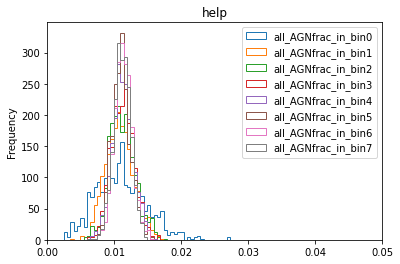

In [20]:
# plot distributions
iAGNf_df.plot.hist(bins=50, histtype='step', density=True)
plt.title('help')
plt.xlim(0, 0.05)

(0.0, 0.05)

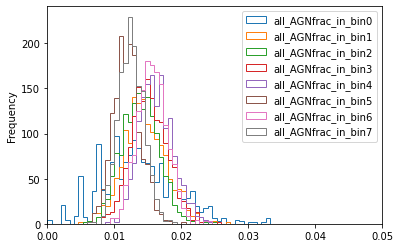

In [19]:
pAGNf_df.plot.hist(bins=50, histtype='step', density=True)
plt.xlim(0, 0.05)

In [12]:
### should double check the movement of all thus data

In [21]:
# make AGN fraction vectors
pdata = [pAGNf_df[col] for col in pAGNf_df]
idata = [iAGNf_df[col] for col in pAGNf_df]

# make position vector
kpc_meds = [ ( ( float((bins[key].split('-'))[0]) + float((bins[key].split('-'))[1]) ) / 2 ) for key in bins ]

# define violin plot width
vwidth = float((bins['bin0'].split('-'))[1]) - float((bins['bin0'].split('-'))[0])

# make an AGN enhancment vector
AGN_enh = [(pdata[i] / idata[i]) for i in range(0, len(pdata))]

# should make some dynamic vector in case I want to increase pair sample out to 150 kpc or something

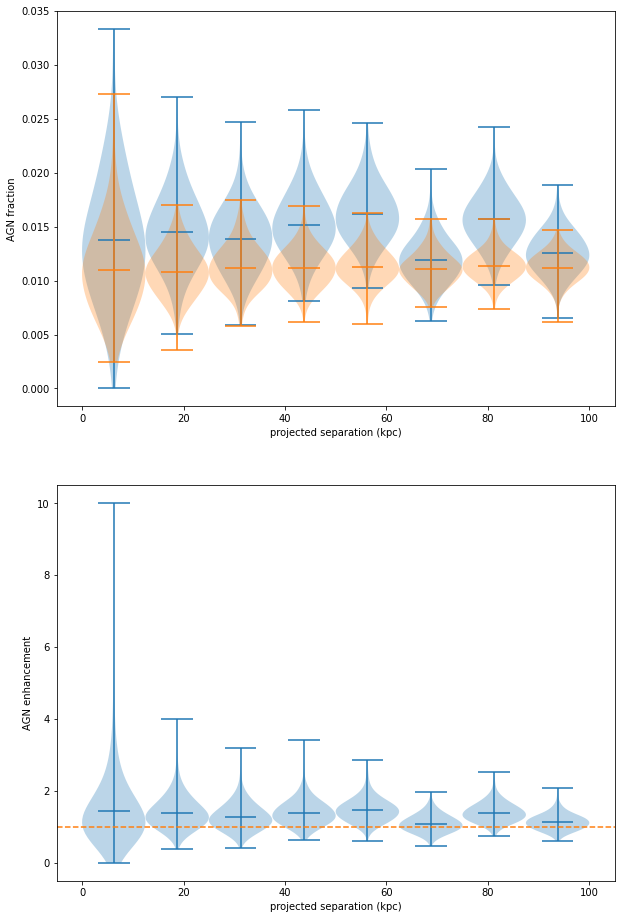

In [22]:
# make violin plots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 16))
axs[0].violinplot(pdata, kpc_meds, points=100, widths=vwidth, showmeans=True,
                     showextrema=True, showmedians=False, bw_method=0.5)
axs[0].violinplot(idata, kpc_meds, points=100, widths=vwidth, showmeans=True,
                     showextrema=True, showmedians=False, bw_method=0.5)
# axs[0].set_title('Results', fontsize=20)
axs[0].axis(xmin=-5,xmax=105)
axs[0].set_xlabel('projected separation (kpc)')
axs[0].set_ylabel('AGN fraction')

axs[1].violinplot(AGN_enh, kpc_meds, points=100, widths=vwidth, showmeans=True,
                     showextrema=True, showmedians=False, bw_method=0.5)
axs[1].plot([-5,105], [1,1], linestyle='--')
axs[1].axis(xmin=-5,xmax=105)
axs[1].set_xlabel('projected separation (kpc)')
axs[1].set_ylabel('AGN enhancement')

plt.show()



In [24]:
# right now there is not evidence for AGN enhancement
# a few things:
## write code to account for pairs where a partner falls below a mass limit
### simply just say that the prime needs to be greater that 8.5, and any partner needs to be within a mass ratio limit
## seal with duplicat issue where mass ratio = 0, currently some unaccounted for duplicates
## currently, we are using zhi and low values for the mFDa approach, which is not consistent with the draws
### additionally, these are 68% confidence intervals
## control sampe not exactly representative of the pair sample

# let's say the current version of the code is version 1.0
# these tasts will be implemented as different versions
